## Modélisation 

Le but de cette partie est de prédire la consommation d'électricité par habitants à partir des données météo que nous avons récoltées. Nous nous appuyons sur les variations géographiques de températures et d'ensoleillement en France pour identifier une corrélation significative entre consommation d'électricité et température moyenne annuelle.\
Les régressions menées ci-dessous laissent toutefois apparaître que les données que nous avons à disposition ne sont pas suffisantes pour prédire la consommation d'électricité du secteur résidentiel en fonction des données météo. Nous sommes conscients du faible nombre de données que nous avons à disposition (il n'y a qu'une petite centaine de départements en France) ; il aurait sûrement été plus pertinent de mener cette étude à partir de données à une échelle temporelle plus fine, par exemple mensuelle, afin de capturer les effets de saisonnalité. Nous n'avons cependant pas trouvé de telles données, ce qui explique notre tentative de prédire la consommation en se fondant uniquement sur des variations géographiques de températures moyennes.\
Enfin, nous sommes conscients qu'il nous faudrait ajouter des variables de contrôle sûrement pertinentes comme la part de résidence secondaire, le revenu moyen du département et/ou le taux d'équipement en chauffages éléectriques et panneaux solaires dans chaque département. Ces données, très différentes, ne peuvent pas toutes être trouvées facilement.

In [ ]:
!pip install import-ipynb
!pip install seaborn
!pip install statsmodels

In [ ]:
# Données 
import import_ipynb
import declarations_AV as dec
import Recuperation_des_donnees_AV as donnees
import Carte_ensoleillement_AV as sol

In [4]:
# Modélisation
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf

### 1- Création d'un dataset alliant les données de consommation, températures et ensoleillement récupérées

Avant de commencer la modélisation, il est nécessaire de rassembler toutes les données collectées que nous utiliserons dans la modélisation dans un même DataFrame. Nous avons choisi de nous intéresser à l'année 2019, car il s'agit de celle présentant le plus grand écart entre températures moyennes maximale et minimale.

In [8]:
# Détermination de l'année présentant le plus grand écart entre températures moyennes minimale et maximale
print("2018 : ", donnees.dico_df_temp[2018]["tmoy"].max()- donnees.dico_df_temp[2018]["tmoy"].min())
print("2019 : ", donnees.dico_df_temp[2019]["tmoy"].max()- donnees.dico_df_temp[2019]["tmoy"].min())
print("2020 : ", donnees.dico_df_temp[2019]["tmoy"].max()- donnees.dico_df_temp[2020]["tmoy"].min())

2018 :  7.386876712328766
2019 :  7.601424657534249
2020 :  7.092247323901493


In [9]:
df_2019=donnees.dico_df_cons_tot[2019].merge(donnees.dico_df_temp[2019], how='left', left_on='Code Département', right_on='code_insee_departement')
df_2019=df_2019.merge(sol.ensoleillement, how='left', left_on='Libellé Département', right_on='Départements')
df_2019=df_2019.drop(['code_insee_departement', 'departement','Départements'], axis='columns')
df_2019['tmoy']=round(df_2019['tmoy'],3)
df_2019.head(3)

,Code Département,Libellé Département,Consommation Résidentiel (MWh),Population,Consommation Résidentiel par habitant (MWh),tmoy,tmax,tmin,Temps d'ensoleillement (jours/an)
0,01,Ain,1.772622e+06,652432,2.717,12.291,38.4,-6.8,182.0
1,02,Aisne,1.302495e+06,531345,2.451,11.403,40.7,-5.7,142.0
2,03,Allier,8.791846e+05,335975,2.617,12.577,41.3,-7.0,161.0


In [10]:
# On observe le détail du nombre de valeurs manquantes par variables
print("NaN occurrences in Columns:")
print(df_2019.isnull().sum(axis=0))

NaN occurrences in Columns:
Code Département                               0
Libellé Département                            0
Consommation Résidentiel  (MWh)                0
Population                                     0
Consommation Résidentiel par habitant (MWh)    0
tmoy                                           0
tmax                                           0
tmin                                           0
Temps d'ensoleillement (jours/an)              4
dtype: int64


In [11]:
# On supprime les départements pour lesquels on a des valeurs d'ensoleillement manquantes
df_2019=df_2019.dropna(how='any')
df_2019.shape

(92, 9)

### 2- Premières visualisations des corrélations entre les variables

Avant de se lancer dans la modélisations, on visualise les potentielles relation entre notre variable d'intérêt, qui sera ici liée à la consommation d'électricité par habitant du secteur résidentiel et nos variables explicatives. Ces dernières sont le nombre de jours d'ensoleillement et les températures moyennes, minimales et maximales.

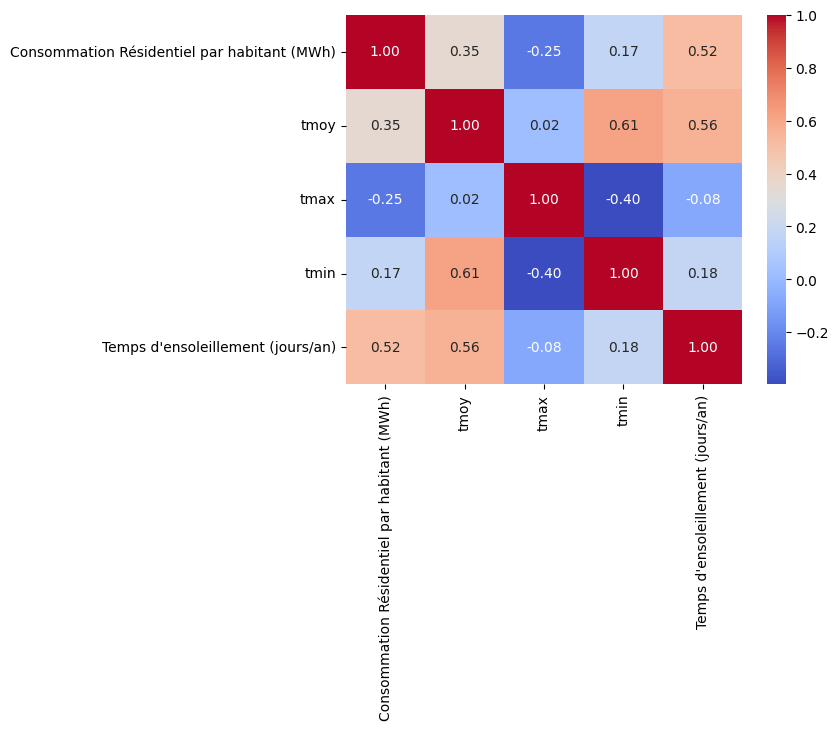

In [12]:
# Matrice de corrélation graphique
g1 = sns.heatmap(df_2019.drop(['Code Département','Libellé Département','Consommation Résidentiel  (MWh)',
                               'Population'], axis = 1).corr(), cmap='coolwarm', annot=True, fmt=".2f")

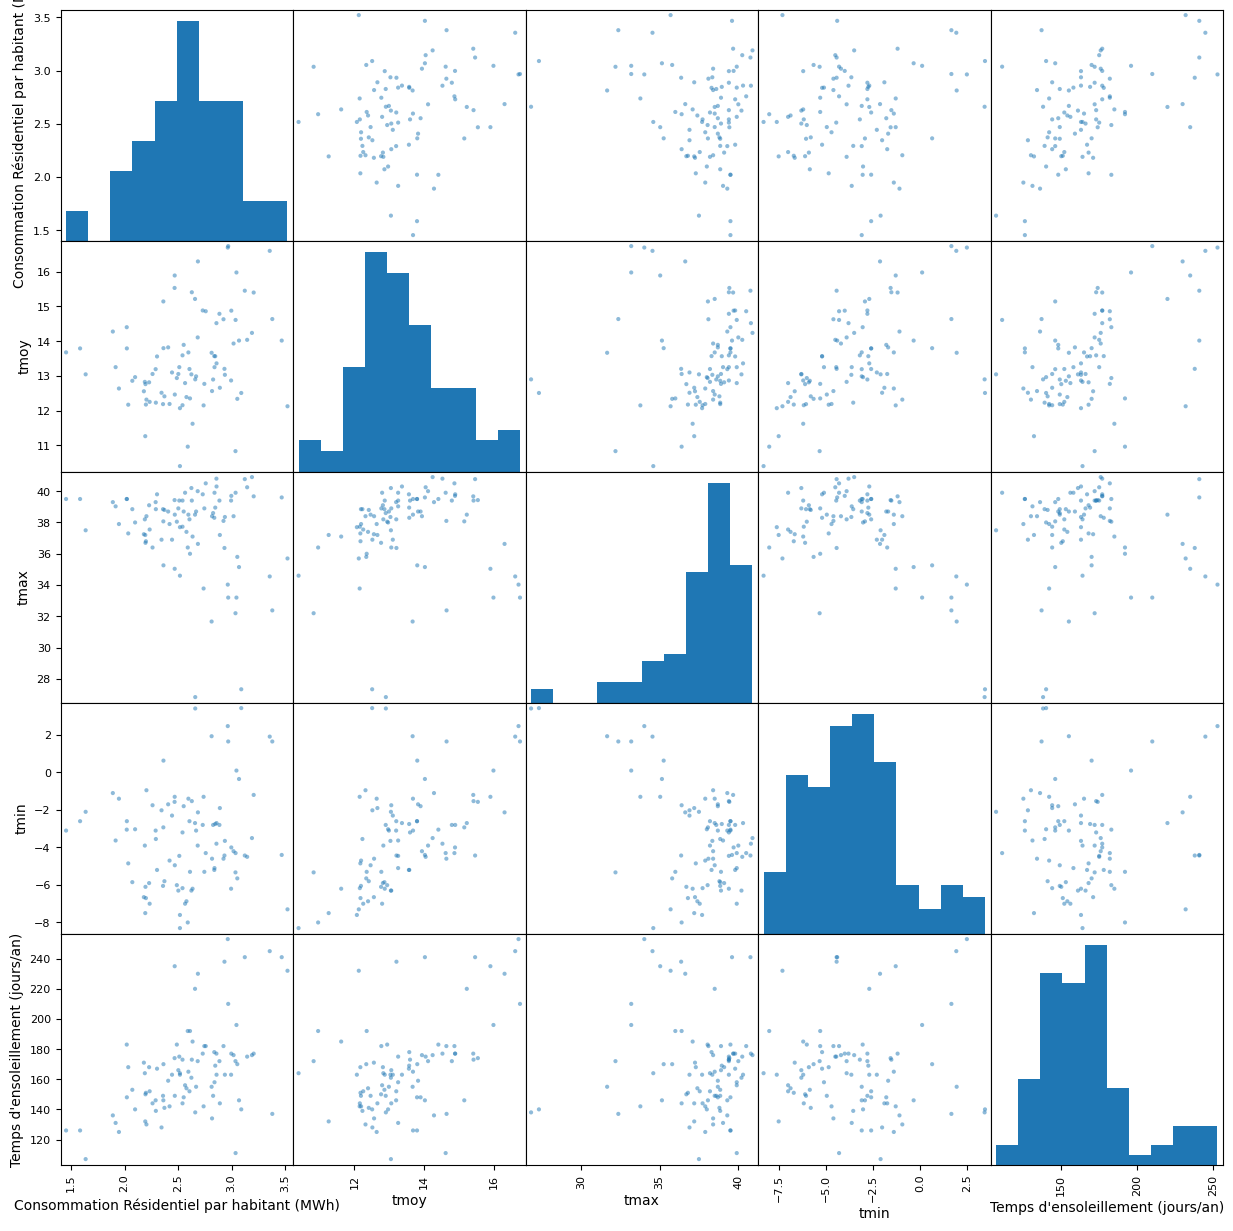

In [8]:
ax = pd.plotting.scatter_matrix(df_2019.drop(['Code Département','Libellé Département','Consommation Résidentiel  (MWh)',
                               'Population'], axis = 1), figsize = (15,15))

Sous réserve que ces corrélations soient significatives, la consommation d'électricité par habitant du secteur résidentiel est corrélé positivement avec l'ensoleillement : une augmentation du nombre de jours d'ensoleillement entraîne une augmentation de la consommation d'électricité. Ceci peut paraître surprenant, car un jour ensoleillé pourrait entraîner une diminution de l'éclairage par exemple. \
De plus, la matrice des corrélations montre une faible corrélation positive entre consommation d'électricité et températures moyenne et minimale. Une augmentation des températures moyenne et minimale entraîneraient une augmentation de la consommation d'électricité par habitant. Enfin, on observe une faible corrélation négative entre température maximale et consommation d'électricité. Associés entre eux ces résultats sont un peu surprenants. \
Ces premieres observations nous poussent à essayer d'améliorer les variables que nous considèrerons pour une régression. On choisit donc de créer des variables catégorielles de température. En divisant l'intervalle des températures moyennes relevées en 2019 en trois intervalles de même longueur, on créé ainsi trois catégories de départements, "Haute Température", "Moyenne Température" et "Basse Température". Nous espérons grâce à ces variables pouvoir mieux réussir à capturer l'effet des températures sur la consommation d'électricité. 

In [13]:
# Création d'une variable catégorielle pour les différentes températures moyennes
print("Les températures moyennes des départements français en 2020 s'étendent de "+f"{min(df_2019['tmoy'])}°C à "+ f"{max(df_2019['tmoy'])}°C")
df_2019['Catégories Températures']=pd.cut(df_2019['tmoy'],bins=3, labels=['Basse Température', 'Moyenne Température','Haute Température'])
df_2019.head(3)

Les températures moyennes des départements français en 2020 s'étendent de 9.891°C à 16.768°C


,Code Département,Libellé Département,Consommation Résidentiel (MWh),Population,Consommation Résidentiel par habitant (MWh),tmoy,tmax,tmin,Temps d'ensoleillement (jours/an),Catégories Températures
0,01,Ain,1.772622e+06,652432,2.717,12.291,38.4,-6.8,182.0,Moyenne Température
1,02,Aisne,1.302495e+06,531345,2.451,11.403,40.7,-5.7,142.0,Basse Température
2,03,Allier,8.791846e+05,335975,2.617,12.577,41.3,-7.0,161.0,Moyenne Température


In [14]:
# Création de dummies pour deux des catégories de température
df_2019['Basse Température']=1*(df_2019['Catégories Températures']=='Basse Température')
df_2019['Haute Température']=1*(df_2019['Catégories Températures']=='Haute Température')
df_2019['Moyenne Température']=1*(df_2019['Catégories Températures']=='Moyenne Température')
df_2019.head(3)

,Code Département,Libellé Département,Consommation Résidentiel (MWh),Population,Consommation Résidentiel par habitant (MWh),tmoy,tmax,tmin,Temps d'ensoleillement (jours/an),Catégories Températures,Basse Température,Haute Température,Moyenne Température
0,01,Ain,1.772622e+06,652432,2.717,12.291,38.4,-6.8,182.0,Moyenne Température,0,0,1
1,02,Aisne,1.302495e+06,531345,2.451,11.403,40.7,-5.7,142.0,Basse Température,1,0,0
2,03,Allier,8.791846e+05,335975,2.617,12.577,41.3,-7.0,161.0,Moyenne Température,0,0,1


In [16]:
print("Les nombres de départements et températures moyennes minimales et maximales pour chaque catégorie sont :")
print("Basse Température : ", df_2019['Basse Température'].sum(),";", 
      df_2019.loc[df_2019['Basse Température']== 1,'tmoy'].min(),";", 
      df_2019.loc[df_2019['Basse Température']== 1,'tmoy'].max())
print("Haute Température : ", df_2019['Haute Température'].sum(),";",
      df_2019.loc[df_2019['Haute Température']== 1,'tmoy'].min(),";",
      df_2019.loc[df_2019['Haute Température']== 1,'tmoy'].max())
print("Moyenne Température : ", df_2019['Moyenne Température'].sum(),";",
      df_2019.loc[df_2019['Moyenne Température']== 1,'tmoy'].min(),";", 
      df_2019.loc[df_2019['Moyenne Température']== 1,'tmoy'].max())

Les nombres de départements et températures moyennes minimales et maximales pour chaque catégorie sont :
Basse Température :  27 ; 9.891 ; 12.17
Haute Température :  14 ; 14.627 ; 16.768
Moyenne Température :  51 ; 12.187 ; 14.413


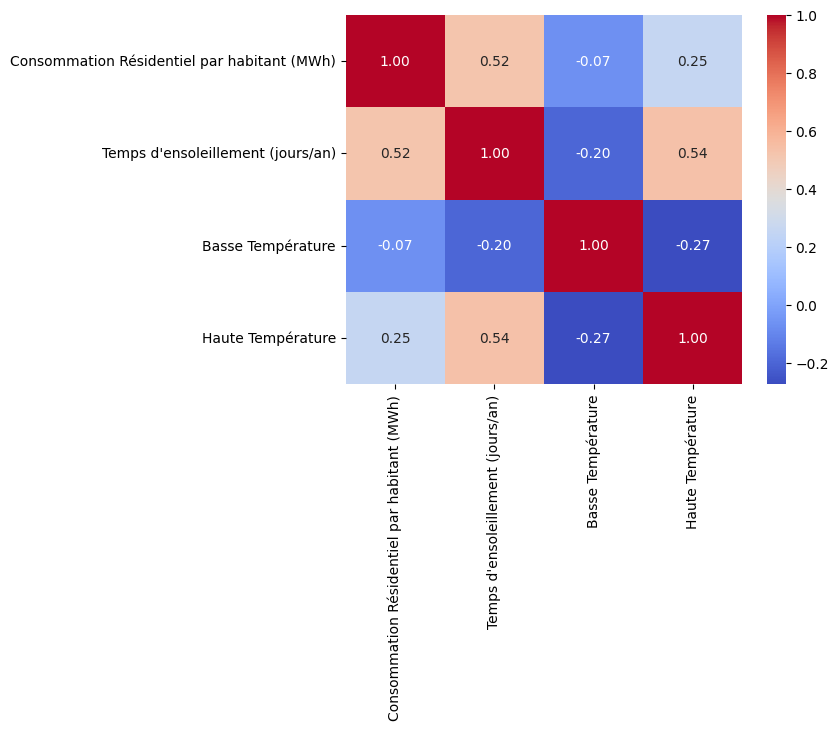

In [17]:
# Que donne la matrice des corrélations graphiques dans ce cas ?
g2 = sns.heatmap(df_2019.drop(['Code Département','Libellé Département','Consommation Résidentiel  (MWh)',
                               'Population','tmoy','Catégories Températures','tmin','tmax','Moyenne Température'], axis = 1).corr(), cmap='coolwarm', annot=True, fmt=".2f")

La corrélation entre temps d'ensoleillement et consommation d'électricité demeure et reste la plus importante. Il apparaît une corrélation positive entre la proportion de départements dans la catégorie "Haute Température", c'est-à-dire avec une température moyenne dans la tranche haute, et la consommation d'électricité par habitant. Une augmentation du nombre de départements avec de hautes températures moyennes serait associée à une augmentation de la consommation d'électricité. Le tableau laisse aussi apparaître une faible corrélation négative avec la variable de consommation et le fait d'être dans la tranche "Basse Température". Ces corrélations existent, sous réserve qu'elles soient significatives, information que nous n'avons pas à partir de ces tableaux.\
Si l'on considère que la part la plus importante de l'électricité consommée est due aux fortes chaleurs de l'été et au fonctionnement des appareils électriques de rafraîchissement ou qu'une part importante de la population se déplace dans les départements du Sud durant l'été, ces corrélations pourraient faire sens... Il n'est pas clair néanmoins que la transformation de la variable "<i>tmoy</i>" en variables catégorielles ait un avantage quelconque.

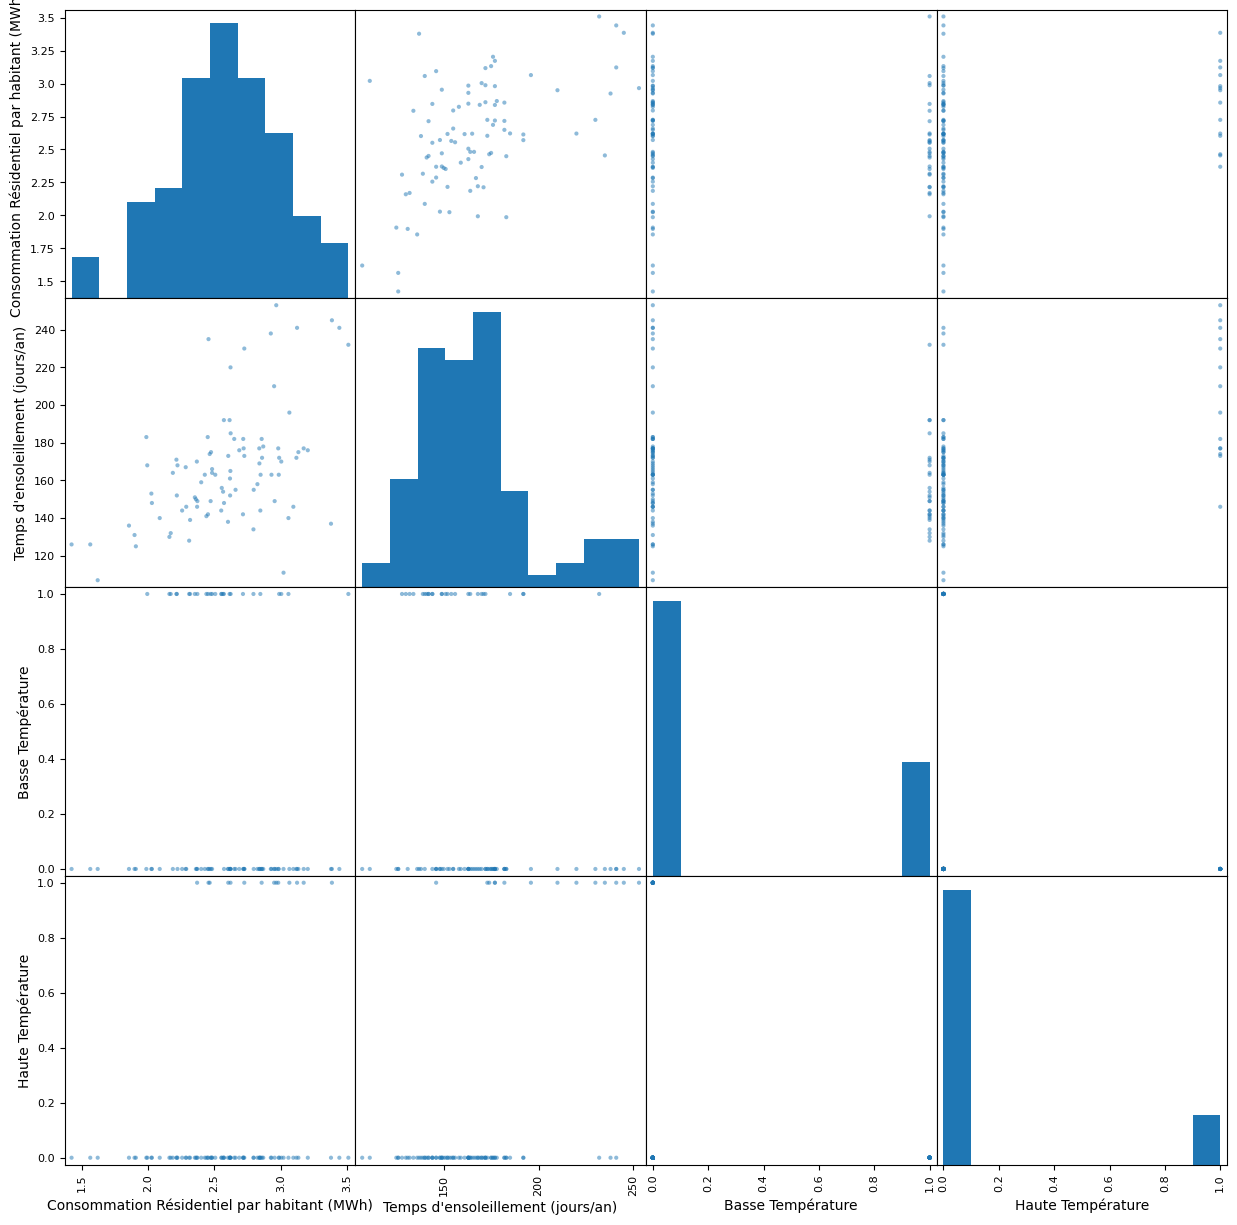

In [18]:
ax = pd.plotting.scatter_matrix(df_2019.drop(['Code Département','Libellé Département','Consommation Résidentiel  (MWh)',
                               'Population','tmoy','Catégories Températures','tmin','tmax','Moyenne Température'], axis = 1), figsize = (15,15))

Un défaut de notre base de données est le faible nombre d'observations que nous avons. Une solution pourrait être d'agrégé les bases de données de plusieurs années différentes ne présentant pas de trop grandes variations de niveaux de consommation d'électricité entre départements d'une année à l'autre à niveaux de températures égaux. Ceci rajouterait certes des points mais ne diversifierait pas vraiment nos données. Quant à agréger des bases de données avec des niveaux de consommations très différents d'une année à l'autre, par exemple 2017 et 2018, cela n'apparaît pas non plus pertinent car la consommation d'électricité peut dépendre d'effets propres à une année (comme une forte variation du prix de l'électricité par exemple).

Etant donné notre nombre restreint de données, il va sûrement être difficile d'obtenir par la suite un modèle économétrique de prédiction satisfaisant. 

### 3- Premières régressions 

Pour les régressions effectuées dans cette partie nous avons choisi de manipuler plusieurs fonctions de différents packages : la fonction `LinearRegression` de `sickitlearn`, le package `statsmodels` qui fournit les mêmes résulats que `LinearRegression` dans un tableau récapitulatif et la fonction `train_test_split` du package `sickitlearn`.

#### 3.1- En utilisant les variables catégorielles

In [19]:
lm=LinearRegression()
X=df_2019[["Temps d'ensoleillement (jours/an)","Haute Température","Basse Température"]]
Y=df_2019[["Consommation Résidentiel par habitant (MWh)"]]
lm.fit(X,Y)
predictions = lm.predict(X)
print("intercept : ",lm.intercept_, "; coefficients :" ,lm.coef_)
print("R² :",lm.score(X, Y))

intercept :  [1.36295694] ; coefficients : [[ 0.00737145 -0.02988357  0.03024831]]
R² : 0.27042799521186445


In [20]:
# Régression linéaire avec statsmodels
x_vars=["Temps d'ensoleillement (jours/an)","Haute Température","Basse Température"]

df_reg=df_2019[['Consommation Résidentiel par habitant (MWh)']+x_vars].copy()

X2 = sm.add_constant(df_reg[x_vars])
results = sm.OLS(df_reg[['Consommation Résidentiel par habitant (MWh)']], X2).fit()
print(results.summary())

                                         OLS Regression Results                                        
Dep. Variable:     Consommation Résidentiel par habitant (MWh)   R-squared:                       0.270
Model:                                                     OLS   Adj. R-squared:                  0.246
Method:                                          Least Squares   F-statistic:                     10.87
Date:                                         Thu, 28 Dec 2023   Prob (F-statistic):           3.81e-06
Time:                                                 17:22:15   Log-Likelihood:                -34.445
No. Observations:                                           92   AIC:                             76.89
Df Residuals:                                               88   BIC:                             86.98
Df Model:                                                    3                                         
Covariance Type:                                     nonrobust  

Le R² associé à la première régression ci-dessus vaut 0.27. Il est donc relativement faible. De plus, on retrouve une corrélation positive entre nombre de jours d'ensoleillement et consommation d'électricité par habitant : une augmentation d'un jour d'ensoleillement est ici associé à une hausse de 0.0074 MWh de consommation d'électricité par habitant. Ce coefficient est significatif aux seuils de 10, 5 et 1%. On ne retrouve en revanche pas les corrélations entre le nombre de départements dans les catégories "<i>Haute Température</i>" et "<i>Basse Température</i>" et la consommation d'électricité : l'intervalle de confiance est grand au point qu'il n'est pas possible de dire si la corrélation est positive ou négative entre ces variables. La création de ces catégories ne semble donc pas être une bonne option.

In [21]:
# Approche Machine Learning/validation croisée avec SickitLearn
X_train, X_test, y_train, y_test = train_test_split(df_reg.drop(['Consommation Résidentiel par habitant (MWh)'],axis='columns'),
                                                    df_reg['Consommation Résidentiel par habitant (MWh)'],
                                                    test_size=0.1, random_state=121)
ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)

In [22]:
#2. Afficher les valeurs des coefficients
print(ols.intercept_, ols.coef_)

1.4720257273461241 [ 0.00673479 -0.00893833  0.01805958]


In [23]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
rsq = sklearn.metrics.r2_score(y_test, y_pred) 

print('Erreur quadratique moyenne: %.2f'
      % rmse)
# The coefficient of determination: 1 is perfect prediction
print('R²: %.2f'
      % rsq)

Erreur quadratique moyenne: 0.41
R²: 0.27


En utilisant une méthode plus proche de la validation croisée comme ci-dessus, on touve un R² similaire à celui trouvé lors de la régression multiple réalisée avec `statsmodels`.

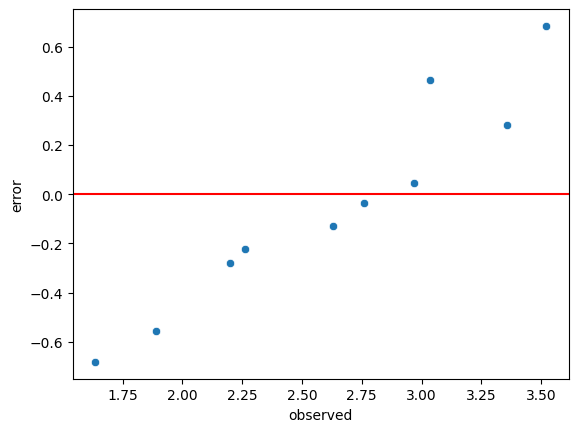

In [15]:
#4. Nuage de points des valeurs observées
tempdf = pd.DataFrame({"prediction": y_pred, "observed": y_test,
                       "error": y_test - y_pred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "error")
g.axhline(0, color = "red")

# La répartition des erreurs n'est clairement pas 
# aléatoire en fonction de $X$.
# Le modèle souffre
# donc d'un problème de spécification. 

#### 3.2- En considérant les variables de départ

In [24]:
X3= sm.add_constant(df_2019[["Temps d\'ensoleillement (jours/an)","tmoy","tmax","tmin"]])
results1 = sm.OLS(df_2019[["Consommation Résidentiel par habitant (MWh)"]], X3).fit()
print(results1.summary())

                                         OLS Regression Results                                        
Dep. Variable:     Consommation Résidentiel par habitant (MWh)   R-squared:                       0.331
Model:                                                     OLS   Adj. R-squared:                  0.300
Method:                                          Least Squares   F-statistic:                     10.74
Date:                                         Thu, 28 Dec 2023   Prob (F-statistic):           4.01e-07
Time:                                                 17:43:44   Log-Likelihood:                -30.482
No. Observations:                                           92   AIC:                             70.96
Df Residuals:                                               87   BIC:                             83.57
Df Model:                                                    4                                         
Covariance Type:                                     nonrobust  

On obtient des résultats plus légèrement plus satisfaisant que précédemment. Le R² est légèrement plus élevé et est égal à 0.33 (R² ajusté égal à 0.30). Ceci provient en partie du plus grand nombre de variables explicatives incluses dans cette régression par rapport à la régression précédente.\
Le temps d'ensoleillement est toujours corrélé positivement à la consommation d'électricité par habitants. Une augmentation d'un jour d'ensoleillement par an est ici associée à une augmentation de la consommation d'électricité de 0.0055 MWh. Ce coefficent est toujours significatif à tous les seuils.\
Par ailleurs, on trouve une corrélation négative entre température maximale et consommation d'électricité. Une augmentation de la température maximale annuelle de 1°C est associée à une diminution de 0.04 MWh de la consommation d'électricité. Ce coefficient est aussi significatif à tous les seuils. Il n'est cependant toujours pas possible d'identifier précisément le signe de la corrélation entre les variables "<i>tmoy</i>" et "<i>tmin</i>" et la consommation d'électricité du fait de la largeur des intervalles de confiance. Les coefficients trouvés ne sont significatifs à aucun seuil. 

#### 3.3- En standardisant les variables

Une autre amélioration de notre modèle pourrait être de comparer les écarts de consommation d'électricté par habitant par rapport à la moyenne de celle-ci plutôt que de considérer uniquement les valeurs de consommation par habitant. 

In [29]:
# Tentative d'amélioration du modèle : on considère plutôt la variable d'écart à la moyenne de la consommation
# d'électricité par habitant
df_2020['Ecart à la moyenne']=df_2020['Consommation Résidentiel par habitant (MWh)']-df_2020['Consommation Résidentiel par habitant (MWh)'].mean()
df_2020["Delta tmoy"]=df_2020["tmoy"]-df_2020["tmoy"].mean()
df_2020["Delta ensoleillement"]=df_2020["Temps d'ensoleillement (jours/an)"]-df_2020["Temps d'ensoleillement (jours/an)"].mean()

df_2020["Conso std"]=(df_2020['Consommation Résidentiel par habitant (MWh)']-df_2020['Consommation Résidentiel par habitant (MWh)'].mean())/df_2020['Consommation Résidentiel par habitant (MWh)'].std()
df_2020["tmoy std"]=(df_2020["tmoy"]-df_2020["tmoy"].mean())/df_2020["tmoy"].std()
df_2020["ensoleillement std"]=(df_2020["Temps d'ensoleillement (jours/an)"]-df_2020["Temps d'ensoleillement (jours/an)"].mean())/df_2020["Temps d'ensoleillement (jours/an)"].std()
df_2020["tmax std"]=(df_2020["tmax"]-df_2020["tmax"].mean())/df_2020["tmax"].std()
df_2020["tmin std"]=(df_2020["tmin"]-df_2020["tmin"].mean())/df_2020["tmin"].std()

df_reg2=df_2020[["Ecart à la moyenne","Haute Température","Basse Température","Temps d'ensoleillement (jours/an)"]].copy()
df_reg3=df_2020[["Conso std","tmoy std","ensoleillement std", "tmax std","tmin std"]].copy()

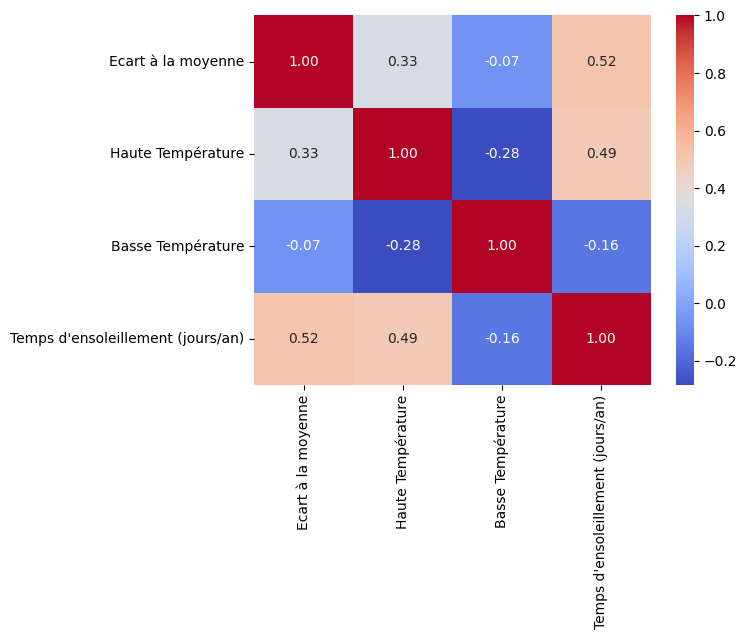

In [24]:
g2 = sns.heatmap(df_reg2.corr(), cmap='coolwarm', annot=True, fmt=".2f")

A ce stade, les résultats sont similaires à ceux obtenus avant. 

In [ ]:
ax2= pd.plotting.scatter_matrix(df_reg2, figsize = (15,15))

In [26]:
# Régression avec Linear_Regression()
new_X=df_reg2[["Temps d'ensoleillement (jours/an)","Haute Température","Basse Température"]]
new_Y=df_reg2[["Ecart à la moyenne"]]
lm.fit(new_X,new_Y)
print("intercept : ",lm.intercept_, "; coefficients :" ,lm.coef_)
print("R² :",lm.score(new_X, new_Y))

intercept :  [-1.10700907] ; coefficients : [[0.00649257 0.10641196 0.03228   ]]
R² : 0.2799346417887232


In [24]:
# Régression linéaire avec statsmodels
X3= sm.add_constant(df_reg2[x_vars])
results2 = sm.OLS(df_reg2[['Ecart à la moyenne']], X3).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:     Ecart à la moyenne   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     11.40
Date:                Thu, 28 Dec 2023   Prob (F-statistic):           2.18e-06
Time:                        12:01:41   Log-Likelihood:                -33.430
No. Observations:                  92   AIC:                             74.86
Df Residuals:                      88   BIC:                             84.95
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [43]:
# Approche Machine Learning
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_reg2.drop(['Ecart à la moyenne'], axis='columns'),
                                                    df_reg2['Ecart à la moyenne'],
                                                    test_size=0.1)
ols2 = LinearRegression().fit(X_train2, y_train2)
y_pred2 = ols2.predict(X_test2)
print(ols2.intercept_, ols2.coef_)

-1.0971925155865851 [0.14889639 0.02227409 0.00646702]


In [44]:
rmse2 = sklearn.metrics.mean_squared_error(y_test2, y_pred2, squared = False)
rsq2 = sklearn.metrics.r2_score(y_test2, y_pred2) 

print('Mean squared error: %.2f'
      % rmse2)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % rsq2)

Mean squared error: 0.32
Coefficient of determination: 0.46


                                         OLS Regression Results                                        
Dep. Variable:     Consommation Résidentiel par habitant (MWh)   R-squared:                       0.310
Model:                                                     OLS   Adj. R-squared:                  0.278
Method:                                          Least Squares   F-statistic:                     9.751
Date:                                         Wed, 27 Dec 2023   Prob (F-statistic):           1.46e-06
Time:                                                 18:46:24   Log-Likelihood:                -31.499
No. Observations:                                           92   AIC:                             73.00
Df Residuals:                                               87   BIC:                             85.61
Df Model:                                                    4                                         
Covariance Type:                                     nonrobust  

In [30]:
new_X2=df_reg3.drop("Conso std", axis='columns')
new_Y2=df_reg3[["Conso std"]]
lm.fit(new_X2,new_Y2)
print("intercept : ",lm.intercept_, "; coefficients :" ,lm.coef_)
print("R² :",lm.score(new_X2, new_Y2))

intercept :  [-3.31703237e-16] ; coefficients : [[ 0.08507579  0.4706559  -0.19359249 -0.00598747]]
R² : 0.309538096962674


In [31]:
# Régression linéaire avec statsmodels
X5= sm.add_constant(df_reg3.drop("Conso std", axis='columns'))
results4 = sm.OLS(df_reg3[["Conso std"]], X5).fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:              Conso std   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     9.751
Date:                Thu, 28 Dec 2023   Prob (F-statistic):           1.46e-06
Time:                        12:10:17   Log-Likelihood:                -113.00
No. Observations:                  92   AIC:                             236.0
Df Residuals:                      87   BIC:                             248.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.106e-16      0

In [40]:
# Approche Machine Learning
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_reg3.drop("Conso std", axis='columns'),
                                                    df_reg3[["Conso std"]],
                                                    test_size=0.1)
ols3 = LinearRegression().fit(X_train3, y_train3)
y_pred3 = ols3.predict(X_test3)
print(ols3.intercept_, ols3.coef_)

[-0.00741984] [[ 0.22932637  0.31734697 -0.26841563 -0.04994961]]


In [41]:
rmse3 = sklearn.metrics.mean_squared_error(y_test3, y_pred3, squared = False)
rsq3 = sklearn.metrics.r2_score(y_test3, y_pred3) 

print('Mean squared error: %.2f'
      % rmse3)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % rsq3)

Mean squared error: 1.02
Coefficient of determination: 0.43


Bien que le R² ne soit pas considérablement amélioré en considérant les variables standardisées et que les coefficients associés à toutes les variables à l'exception de celle de l'ensoleillement ne soient significatifs à aucun seuil, considérer les variables standardisées affecte moins les résultats de l'approche Machine Learning.